In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
import chess
import chess.pgn


2024-08-16 00:56:50.795199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 00:56:51.141698: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 00:56:53.640118: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 00:56:56.076888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 00:56:57.896728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
data = pd.read_csv('data/games.csv')

In [3]:
grouped_eco_labels = {
    'A00': 'Polish (Sokolsky) opening',
    'A01': 'Nimzovich-Larsen attack',
    'A02-A03': "Bird's opening",
    'A04-A09': 'Reti opening',
    'A10-A39': 'English opening',
    'A40-A41': "Queen's pawn",
    'A42': 'Modern defence, Averbakh system',
    'A43-A44': 'Old Benoni defence',
    'A45-A46': "Queen's pawn game",
    'A47': "Queen's Indian defence",
    'A48-A49': "King's Indian, East Indian defence",
    'A50': "Queen's pawn game",
    'A51-A52': 'Budapest defence',
    'A53-A55': 'Old Indian defence',
    'A56': 'Benoni defence',
    'A57-A59': 'Benko gambit',
    'A60-A79': 'Benoni defence',
    'A80-A99': 'Dutch',
    'B00': "King's pawn opening",
    'B01': 'Scandinavian (centre counter) defence',
    'B02-B05': "Alekhine's defence",
    'B06': 'Robatsch (modern) defence',
    'B07-B09': 'Pirc defence',
    'B10-B19': 'Caro-Kann defence',
    'B20-B99': 'Sicilian defence',
    'C00-C19': 'French defence',
    'C20': "King's pawn game",
    'C21-C22': 'Centre game',
    'C23-C24': "Bishop's opening",
    'C25-C29': 'Vienna game',
    'C30-C39': "King's gambit",
    'C40': "King's knight opening",
    'C41': "Philidor's defence",
    'C42-C43': "Petrov's defence",
    'C44': "King's pawn game",
    'C45': "Scotch game",
    'C46': "Three knights game",
    'C47-C49': "Four knights, Scotch variation",
    'C50': "Italian Game",
    'C51-C52': "Evans gambit",
    'C53-C54': "Giuoco Piano",
    'C55-C59': "Two knights defence",
    'C60-C99': "Ruy Lopez (Spanish opening)",
    'D00': "Queen's pawn game",
    'D01': 'Richter-Veresov attack',
    'D02': "Queen's pawn game",
    'D03': 'Torre attack (Tartakower variation)',
    'D04-D05': "Queen's pawn game",
    'D06': "Queen's Gambit",
    'D07-D09': "Queen's Gambit Declined, Chigorin defence",
    'D10-D15': "Queen's Gambit Declined Slav defence",
    'D16': "Queen's Gambit Declined Slav accepted, Alapin variation",
    'D17-D19': "Queen's Gambit Declined Slav, Czech defence",
    'D20-D29': "Queen's gambit accepted",
    'D30-D42': "Queen's gambit declined",
    'D43-D49': "Queen's Gambit Declined semi-Slav",
    'D50-D69': "Queen's Gambit Declined",
    'D70-D79': 'Neo-Gruenfeld defence',
    'D80-D99': 'Gruenfeld defence',
    'E00': "Queen's pawn game",
    'E01-E09': 'Catalan, closed',
    'E10': "Queen's pawn game",
    'E11': 'Bogo-Indian defence',
    'E12-E19': "Queen's Indian defence",
    'E20-E59': 'Nimzo-Indian defence',
    'E60-E99': "King's Indian defence"
}


def map_eco_to_grouped_label(eco_code):
    for key, value in grouped_eco_labels.items():
        if '-' in key:
            start, end = key.split('-')
            if start <= eco_code <= end:
                return value
        elif eco_code == key:
            return value
    return 'Other' 

data['grouped_opening'] = data['opening_eco'].apply(map_eco_to_grouped_label)

# Data Cleaning

In [4]:
def count_illegal_moves(moves):
    board = chess.Board()
    illegal_count = 0
    for move in moves.split():
        try:
            board.push_san(move)
        except:
            illegal_count += 1
            break 
    return illegal_count

In [5]:

data['illegal_moves'] = data['moves'].apply(count_illegal_moves)
illegal_moves_count = data['illegal_moves'].sum()
print(f"Total illegal moves detected: {illegal_moves_count}")

data = data[data['illegal_moves'] == 0]

Total illegal moves detected: 0


/tmp/ipykernel_10884/2584146310.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=grouped_opening_counts.index, x=grouped_opening_counts.values, palette='viridis')


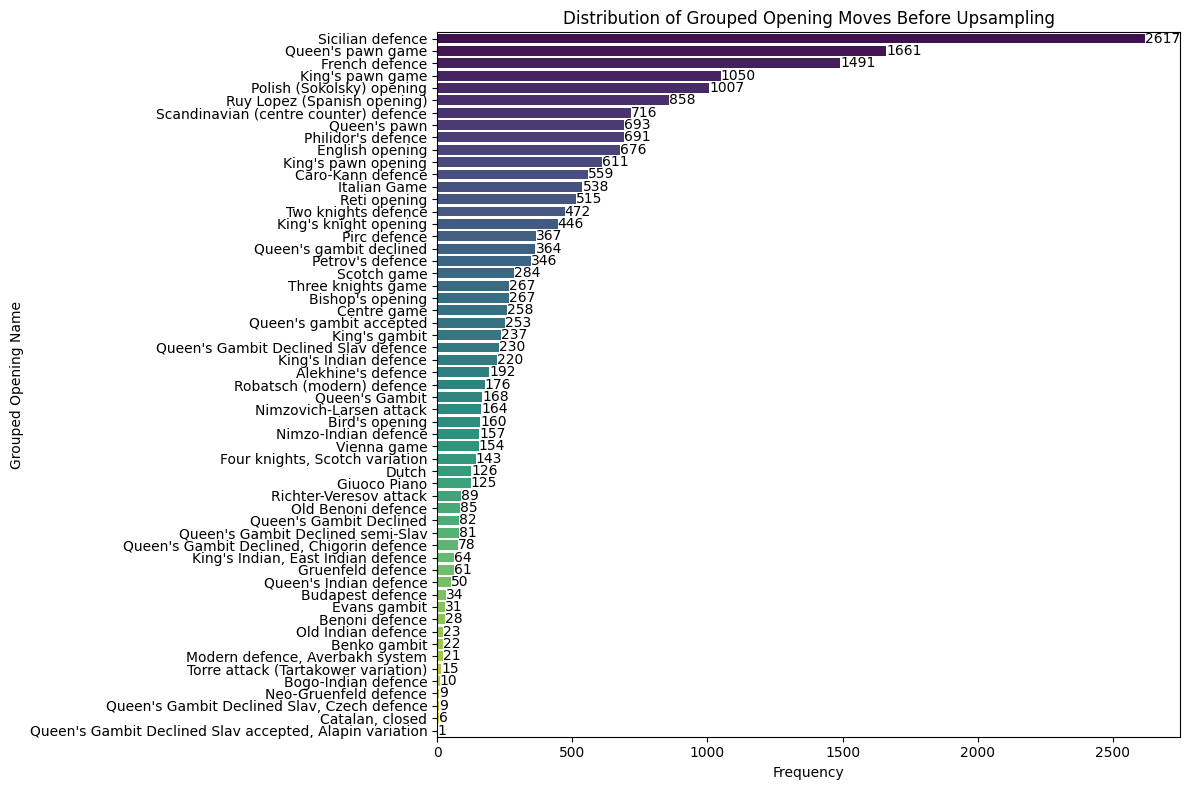

Max count of an opening move category: 2617


/tmp/ipykernel_10884/2584146310.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=upsampled_grouped_opening_counts.index, x=upsampled_grouped_opening_counts.values, palette='magma')


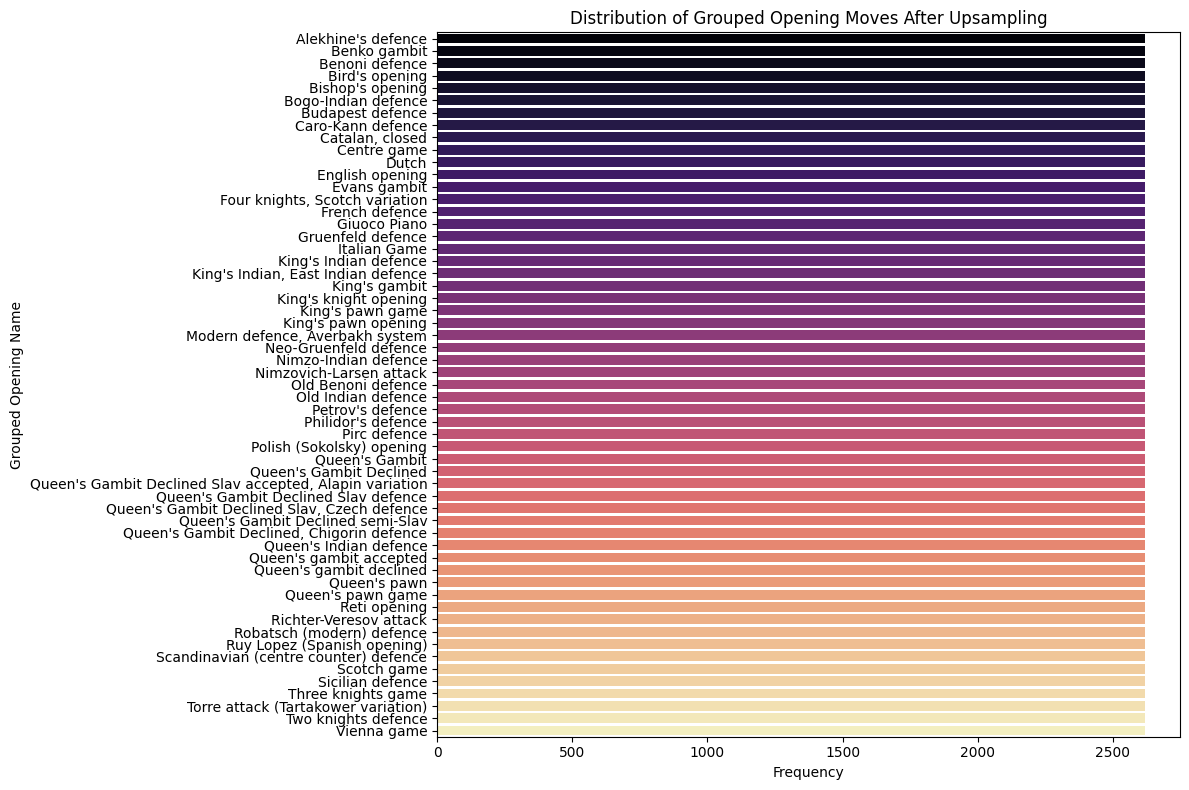

                                 Grouped Opening Name  \
0                                    Sicilian defence   
1                                   Queen's pawn game   
2                                      French defence   
3                                    King's pawn game   
4                           Polish (Sokolsky) opening   
5                         Ruy Lopez (Spanish opening)   
6               Scandinavian (centre counter) defence   
7                                        Queen's pawn   
8                                  Philidor's defence   
9                                     English opening   
10                                King's pawn opening   
11                                  Caro-Kann defence   
12                                       Italian Game   
13                                       Reti opening   
14                                Two knights defence   
15                              King's knight opening   
16                             

In [6]:
plt.figure(figsize=(12, 8))
grouped_opening_counts = data['grouped_opening'].value_counts()
sns.barplot(y=grouped_opening_counts.index, x=grouped_opening_counts.values, palette='viridis')

for index, value in enumerate(grouped_opening_counts.values):
    plt.text(value, index, f'{value}', va='center')

plt.title('Distribution of Grouped Opening Moves Before Upsampling')
plt.xlabel('Frequency')
plt.ylabel('Grouped Opening Name')
plt.tight_layout()
plt.show()

before_upsampling_df = grouped_opening_counts.reset_index()
before_upsampling_df.columns = ['Grouped Opening Name', 'Count Before Upsampling']

max_count = grouped_opening_counts.max()
print(f"Max count of an opening move category: {max_count}")

def upsample_to_balance(data, target_column, max_count):
    groups = data.groupby(target_column)
    upsampled_data = []
    for name, group in groups:
        tiled_group = pd.concat([group] * (max_count // len(group)))
        remainder_group = group.sample(max_count - len(tiled_group), replace=True)
        upsampled_data.append(pd.concat([tiled_group, remainder_group]))
    return pd.concat(upsampled_data)

upsampled_data = upsample_to_balance(data, 'grouped_opening', max_count)

plt.figure(figsize=(12, 8))
upsampled_grouped_opening_counts = upsampled_data['grouped_opening'].value_counts()
sns.barplot(y=upsampled_grouped_opening_counts.index, x=upsampled_grouped_opening_counts.values, palette='magma')
plt.title('Distribution of Grouped Opening Moves After Upsampling')
plt.xlabel('Frequency')
plt.ylabel('Grouped Opening Name')
plt.tight_layout()
plt.show()

after_upsampling_df = upsampled_grouped_opening_counts.reset_index()
after_upsampling_df.columns = ['Grouped Opening Name', 'Count After Upsampling']

comparison_df = pd.merge(before_upsampling_df, after_upsampling_df, on='Grouped Opening Name')

print(comparison_df)

Max number of plays: 28
Min number of plays: 1


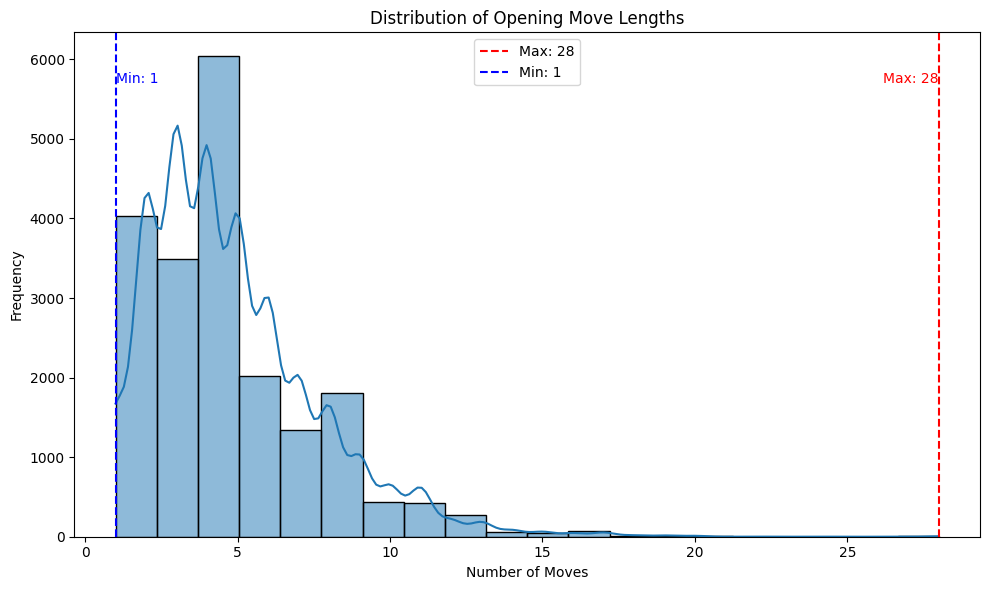

Max number of turns: 349
Min number of turns: 1


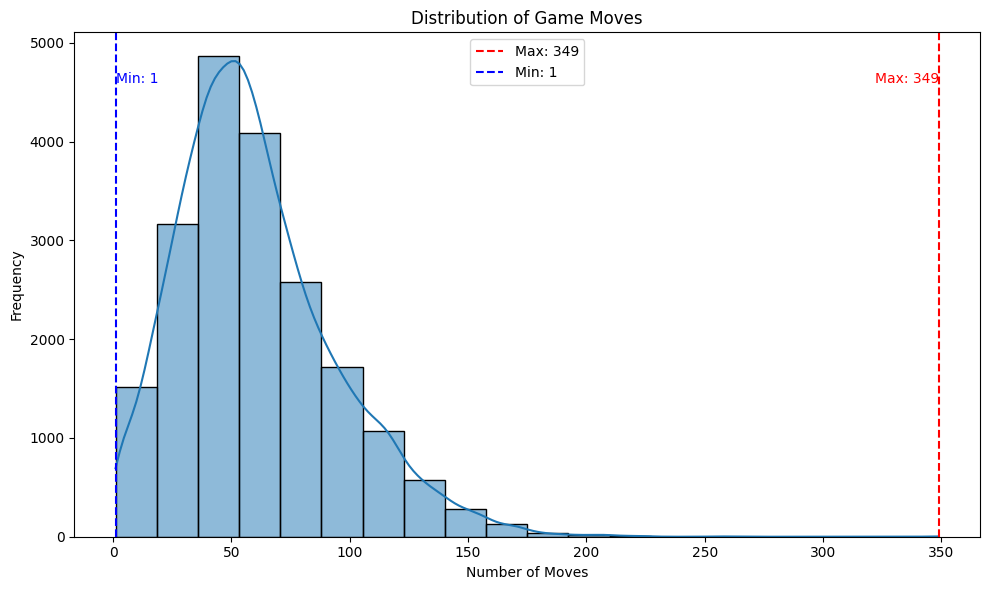

In [7]:
max_ply = data['opening_ply'].max()
min_ply = data['opening_ply'].min()

print(f"Max number of plays: {max_ply}")
print(f"Min number of plays: {min_ply}")

plt.figure(figsize=(10, 6))

sns.histplot(data['opening_ply'], bins=20, kde=True)

plt.axvline(max_ply, color='red', linestyle='--', label=f'Max: {max_ply}')
plt.axvline(min_ply, color='blue', linestyle='--', label=f'Min: {min_ply}')

plt.text(max_ply, plt.ylim()[1] * 0.9, f'Max: {max_ply}', color='red', ha='right')
plt.text(min_ply, plt.ylim()[1] * 0.9, f'Min: {min_ply}', color='blue', ha='left')

plt.title('Distribution of Opening Move Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')

plt.legend()

plt.tight_layout()
plt.show()

max_ply = data['turns'].max()
min_ply = data['turns'].min()

print(f"Max number of turns: {max_ply}")
print(f"Min number of turns: {min_ply}")

plt.figure(figsize=(10, 6))

sns.histplot(data['turns'], bins=20, kde=True)

plt.axvline(max_ply, color='red', linestyle='--', label=f'Max: {max_ply}')
plt.axvline(min_ply, color='blue', linestyle='--', label=f'Min: {min_ply}')

plt.text(max_ply, plt.ylim()[1] * 0.9, f'Max: {max_ply}', color='red', ha='right')
plt.text(min_ply, plt.ylim()[1] * 0.9, f'Min: {min_ply}', color='blue', ha='left')

plt.title('Distribution of Game Moves')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')

plt.legend()

plt.tight_layout()
plt.show()

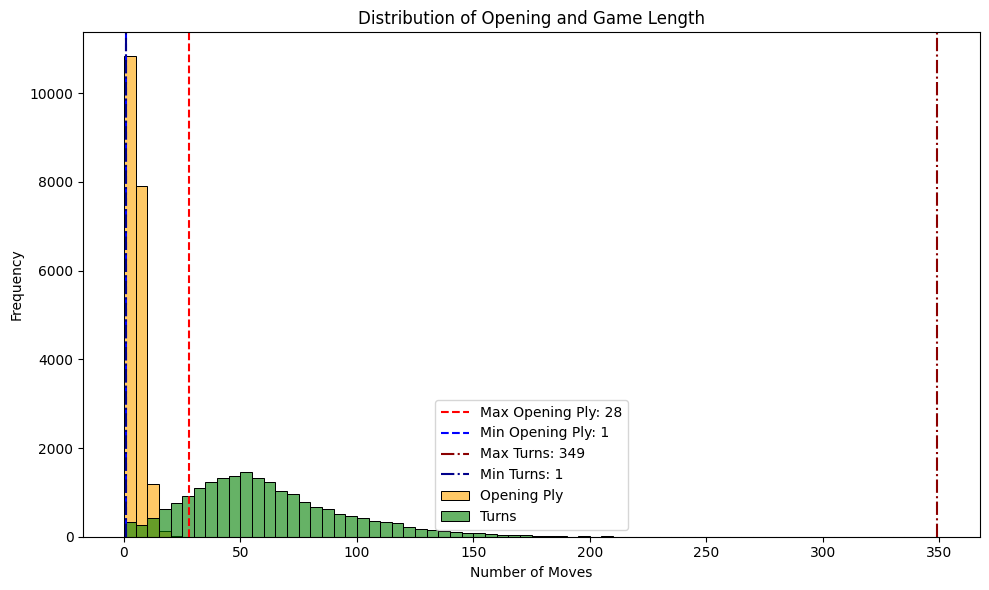

In [8]:
max_opening_ply = data['opening_ply'].max()
min_opening_ply = data['opening_ply'].min()

max_turns = data['turns'].max()
min_turns = data['turns'].min()

plt.figure(figsize=(10, 6))

bins = range(0, max(max_opening_ply, max_turns) + 5, 5)

sns.histplot(data['opening_ply'], bins=bins, kde=False, color='orange', label='Opening Ply', alpha=0.6)

sns.histplot(data['turns'], bins=bins, kde=False, color='green', label='Turns', alpha=0.6)

plt.axvline(max_opening_ply, color='red', linestyle='--', label=f'Max Opening Ply: {max_opening_ply}')
plt.axvline(min_opening_ply, color='blue', linestyle='--', label=f'Min Opening Ply: {min_opening_ply}')

plt.axvline(max_turns, color='darkred', linestyle='-.', label=f'Max Turns: {max_turns}')
plt.axvline(min_turns, color='darkblue', linestyle='-.', label=f'Min Turns: {min_turns}')

plt.title('Distribution of Opening and Game Length')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')

plt.legend()

plt.tight_layout()
plt.show()

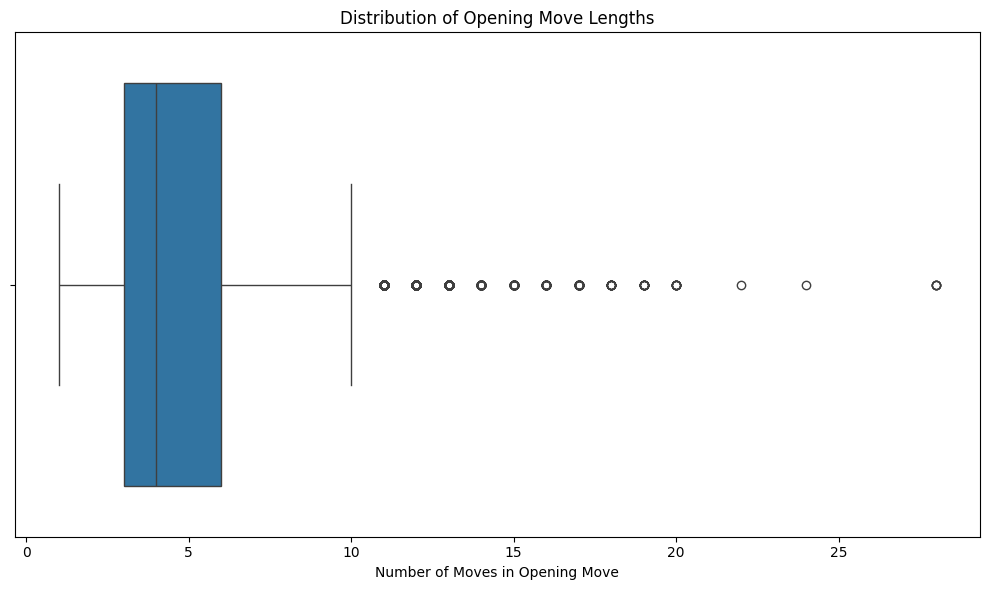

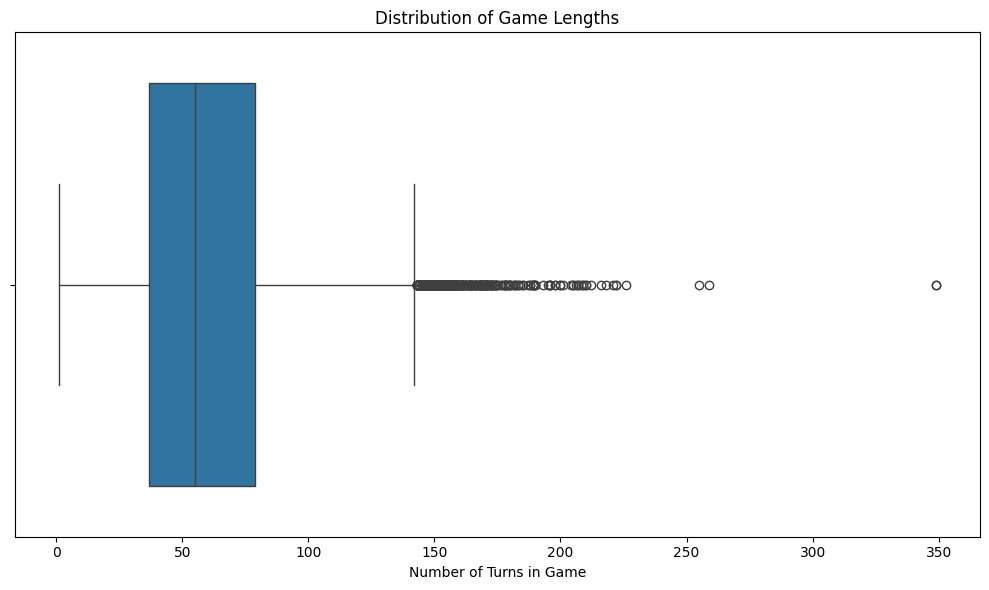

Most extreme 'turns' data point(s):
             id  rated    created_at  last_move_at  turns victory_status  \
11554  pN0ioHNr   True  1.503084e+12  1.503086e+12    349      outoftime   
13859  pN0ioHNr   True  1.503084e+12  1.503086e+12    349      outoftime   

      winner increment_code white_id  white_rating black_id  black_rating  \
11554  white           10+0   shiwen          2194    kijek          2240   
13859  white           10+0   shiwen          2194    kijek          2240   

                                                   moves opening_eco  \
11554  d4 d5 c4 c6 Nf3 Nf6 Nc3 e6 Bg5 h6 Bxf6 Qxf6 Qb...         D30   
13859  d4 d5 c4 c6 Nf3 Nf6 Nc3 e6 Bg5 h6 Bxf6 Qxf6 Qb...         D30   

                                      opening_name  opening_ply  \
11554  Queen's Gambit Declined: Hastings Variation           13   
13859  Queen's Gambit Declined: Hastings Variation           13   

               grouped_opening  illegal_moves  
11554  Queen's gambit declined      

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['opening_ply'])
plt.title('Distribution of Opening Move Lengths')
plt.xlabel('Number of Moves in Opening Move')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=data['turns'])
plt.title('Distribution of Game Lengths')
plt.xlabel('Number of Turns in Game')
plt.tight_layout()
plt.show()

q1_turns = data['turns'].quantile(0.25)
q3_turns = data['turns'].quantile(0.75)
iqr_turns = q3_turns - q1_turns

upper_bound_turns = q3_turns + 1.5 * iqr_turns

extreme_turns = data[data['turns'] > upper_bound_turns]
max_turns = extreme_turns['turns'].max()
print("Most extreme 'turns' data point(s):")
print(data[data['turns'] == max_turns])

In [10]:
duplicate_counter = 0

data_sorted = data.sort_values(by='turns')

rows_to_drop = []

for i in range(len(data_sorted) - 1):
    if data_sorted.iloc[i]['turns'] == data_sorted.iloc[i + 1]['turns']:
        if (data_sorted.iloc[i]['moves'] == data_sorted.iloc[i + 1]['moves'] and
            data_sorted.iloc[i]['white_id'] == data_sorted.iloc[i + 1]['white_id'] and
            data_sorted.iloc[i]['black_id'] == data_sorted.iloc[i + 1]['black_id']):

            duplicate_counter += 1

            rows_to_drop.append(data_sorted.index[i + 1])

data_cleaned = data_sorted.drop(rows_to_drop)

print(f"Duplicates found and removed: {duplicate_counter}")

Duplicates found and removed: 31


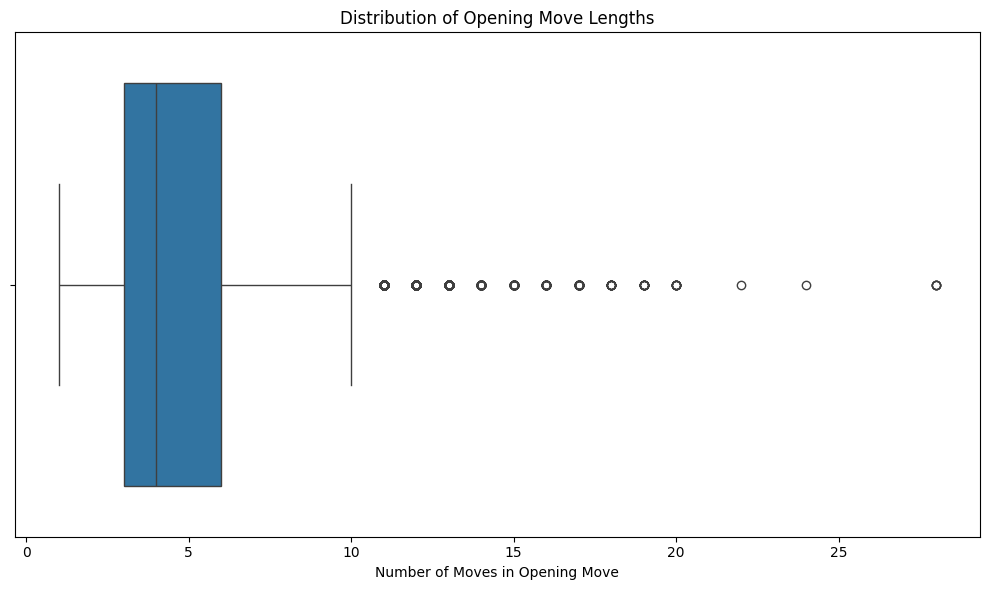

Most extreme 'opening_ply' data point(s):
             id  rated    created_at  last_move_at  turns victory_status  \
4475   9bIIqx54  False  1.480830e+12  1.480840e+12     32      outoftime   
16443  BjplwwJ1   True  1.481225e+12  1.481226e+12     34         resign   
17900  Ms2THNEC   True  1.504184e+12  1.504184e+12     45         resign   
19412  YaQWFwbu   True  1.502744e+12  1.502745e+12     61         resign   

      winner increment_code      white_id  white_rating    black_id  \
4475   black            5+5  ranchowangdu          1500    boseayan   
16443  black           10+0      ramin741          1835  bassem1963   
17900  black            3+8      bratancb          2000  bosspotato   
19412  white           10+0    balikoevsd          1857   craciun05   

       black_rating                                              moves  \
4475           2021  e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 c3 O-O Re...   
16443          1733  e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O b5 Bb3 Be7 Re...   

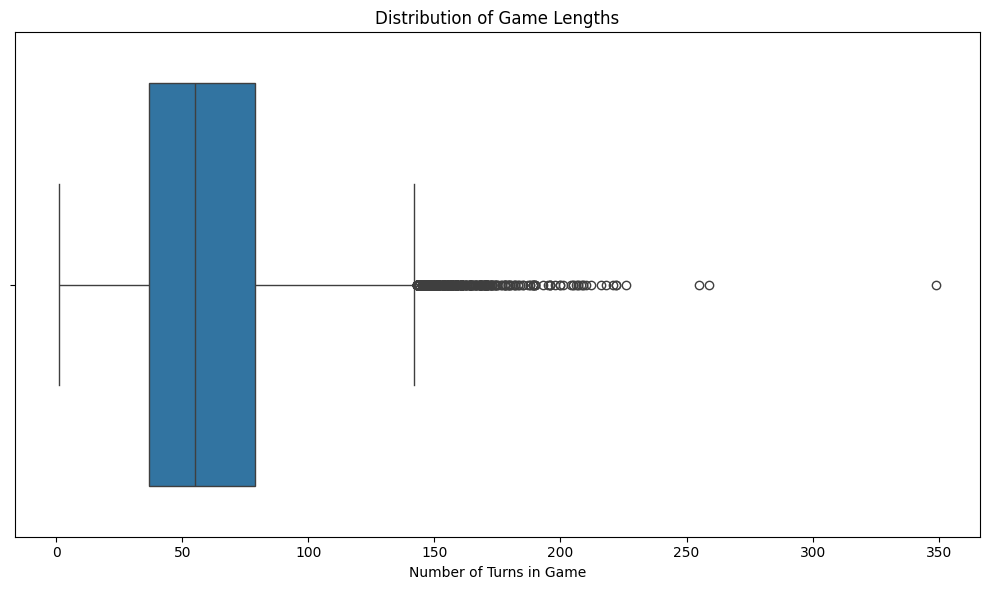

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_cleaned['opening_ply'])
plt.title('Distribution of Opening Move Lengths')
plt.xlabel('Number of Moves in Opening Move')
plt.tight_layout()
plt.show()

q1_opening = data_cleaned['opening_ply'].quantile(0.25)
q3_opening = data_cleaned['opening_ply'].quantile(0.75)
iqr_opening = q3_opening - q1_opening

upper_bound_opening = q3_opening + 1.5 * iqr_opening

extreme_opening_ply = data_cleaned[data_cleaned['opening_ply'] > upper_bound_opening]
max_opening_ply = extreme_opening_ply['opening_ply'].max()
print("Most extreme 'opening_ply' data point(s):")
print(data_cleaned[data_cleaned['opening_ply'] == max_opening_ply])


plt.figure(figsize=(10, 6))
sns.boxplot(x=data_cleaned['turns'])
plt.title('Distribution of Game Lengths')
plt.xlabel('Number of Turns in Game')
plt.tight_layout()
plt.show()

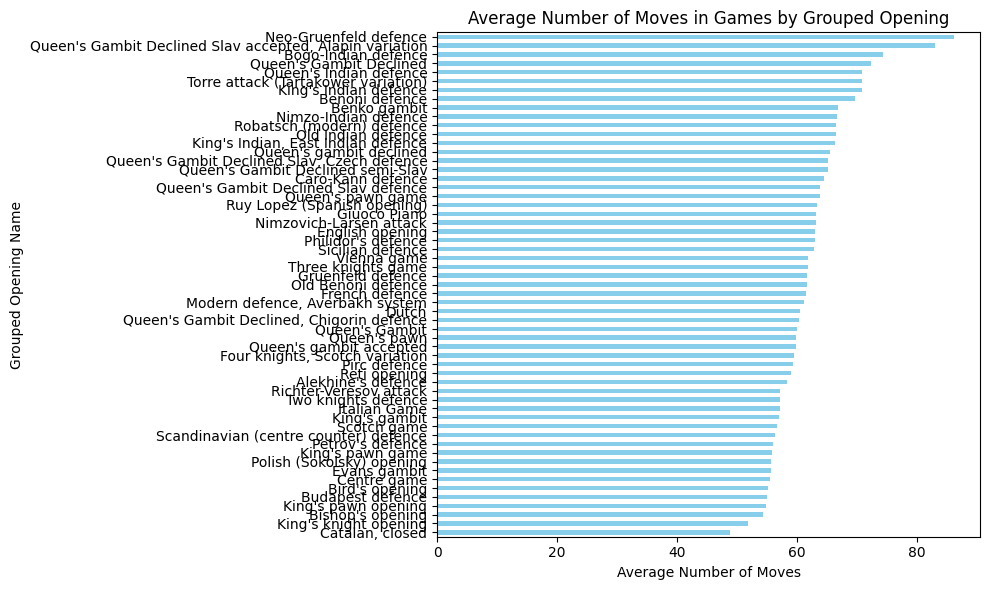

In [12]:
plt.figure(figsize=(10, 6))
avg_moves = data.groupby('grouped_opening')['turns'].mean().sort_values()
avg_moves.plot(kind='barh', color='skyblue')
plt.title('Average Number of Moves in Games by Grouped Opening')
plt.xlabel('Average Number of Moves')
plt.ylabel('Grouped Opening Name')
plt.tight_layout()
plt.show()

In [13]:
invalid_moves = data['moves'].isna().sum() + data['moves'].apply(lambda x: 'invalid' in x).sum()
print(f"Quantity of invalid moves: {invalid_moves}")

Quantity of invalid moves: 0


winner                                              white_win_rate  \
grouped_opening                                                      
Queen's Gambit Declined Slav accepted, Alapin v...      100.000000   
Catalan, closed                                          83.333333   
Neo-Gruenfeld defence                                    66.666667   
Queen's Gambit                                           63.690476   
Old Indian defence                                       60.869565   
King's pawn opening                                      59.738134   
King's knight opening                                    59.641256   
King's gambit                                            58.227848   
Philidor's defence                                       57.308249   
Bishop's opening                                         57.303371   
Queen's Gambit Declined, Chigorin defence                56.410256   
Three knights game                                       55.805243   
Gruenfeld defence   

<Figure size 1400x1000 with 0 Axes>

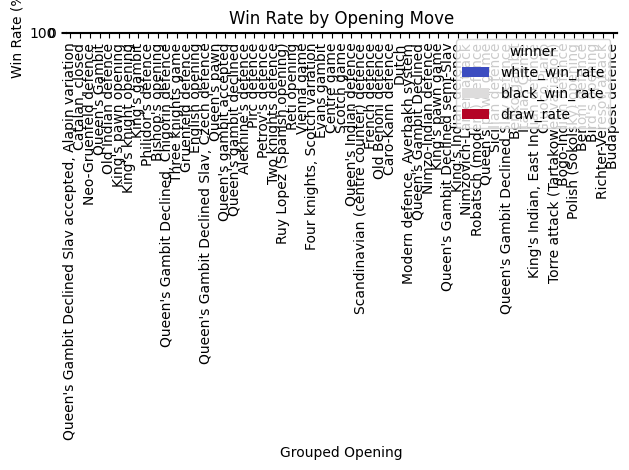

In [14]:
win_rates = data.groupby('grouped_opening')['winner'].value_counts(normalize=True).unstack().fillna(0)

win_rates['white_win_rate'] = win_rates['white'] * 100
win_rates['black_win_rate'] = win_rates['black'] * 100
win_rates['draw_rate'] = win_rates['draw'] * 100 if 'draw' in win_rates.columns else 0

win_rates = win_rates.sort_values(by='white_win_rate', ascending=False)

print(win_rates[['white_win_rate', 'black_win_rate', 'draw_rate']])

plt.figure(figsize=(14, 10))
win_rates[['white_win_rate', 'black_win_rate', 'draw_rate']].plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Win Rate by Opening Move')
plt.xlabel('Grouped Opening')
plt.ylabel('Win Rate (%)')
plt.tight_layout()
plt.show()

# Feature Selection

Not sure how much can be done here by graphs and visualisation

# Data Transformation

/tmp/ipykernel_10884/129059062.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['grouped_opening'], palette='viridis')


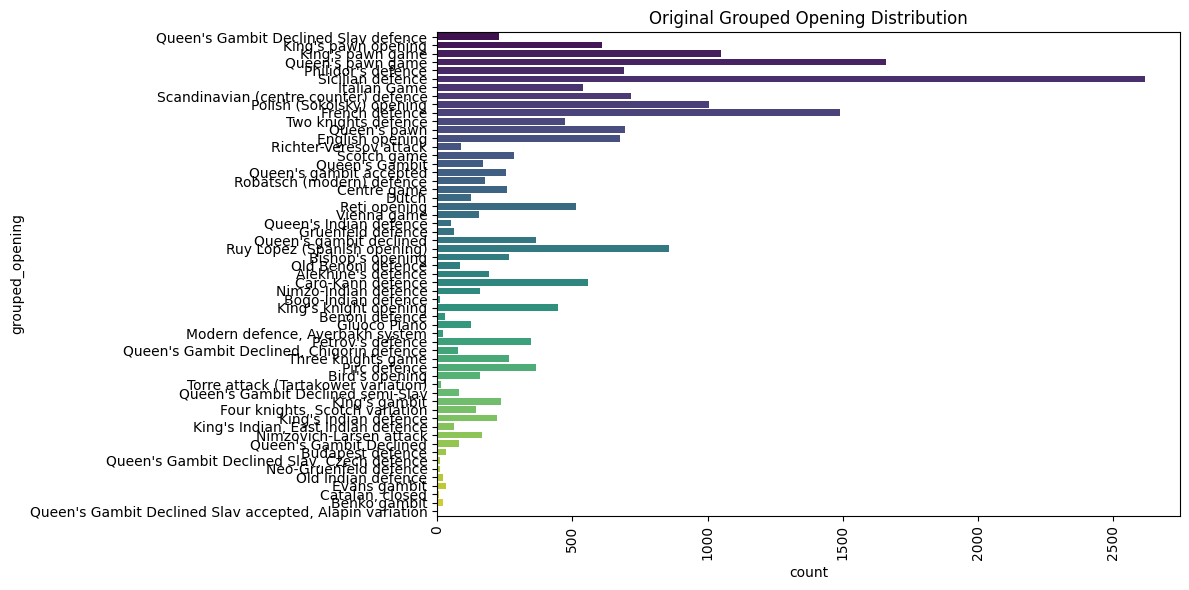

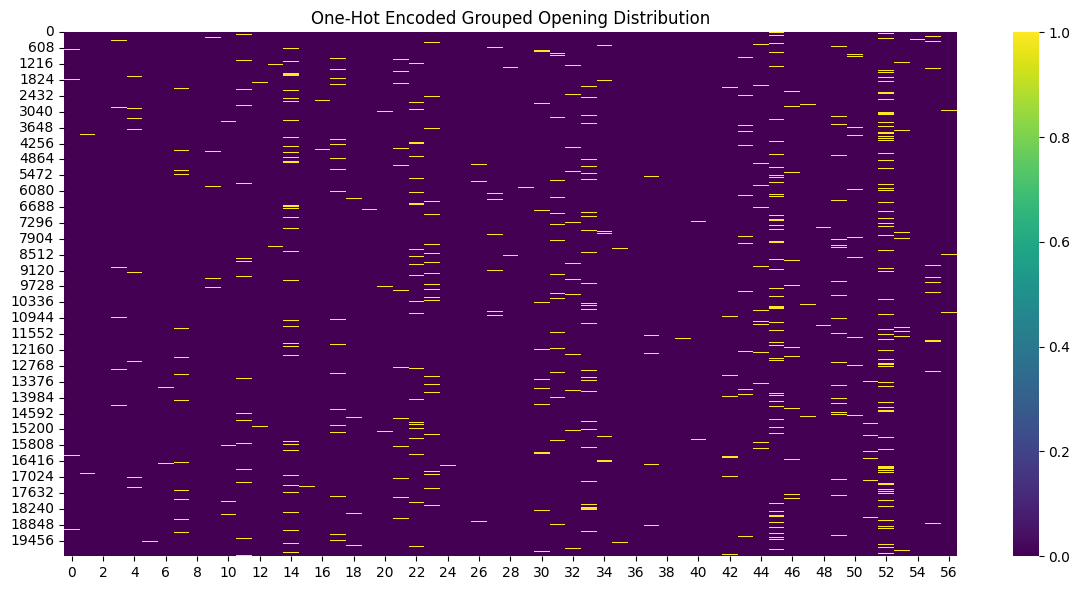

In [15]:
encoder = OneHotEncoder(sparse_output=False)
encoded_openings = encoder.fit_transform(data[['grouped_opening']])

plt.figure(figsize=(12, 6))
sns.countplot(data['grouped_opening'], palette='viridis')
plt.title('Original Grouped Opening Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(encoded_openings, cmap='viridis')
plt.title('One-Hot Encoded Grouped Opening Distribution')
plt.tight_layout()
plt.show()


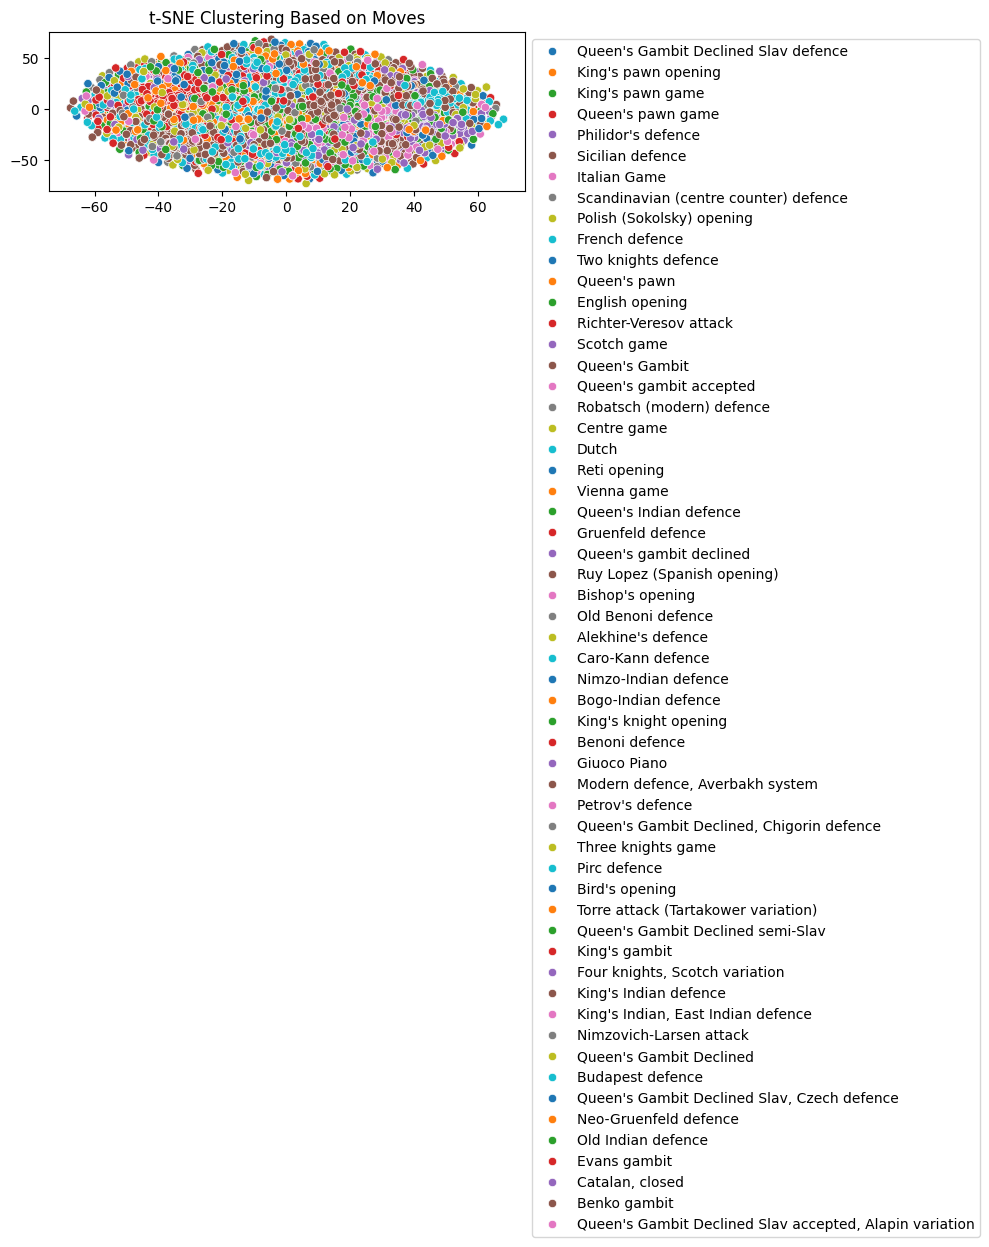

/mnt/c/Users/Maxwell Bruce/Desktop/AML/ChessOpenningMovePredictor/myenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


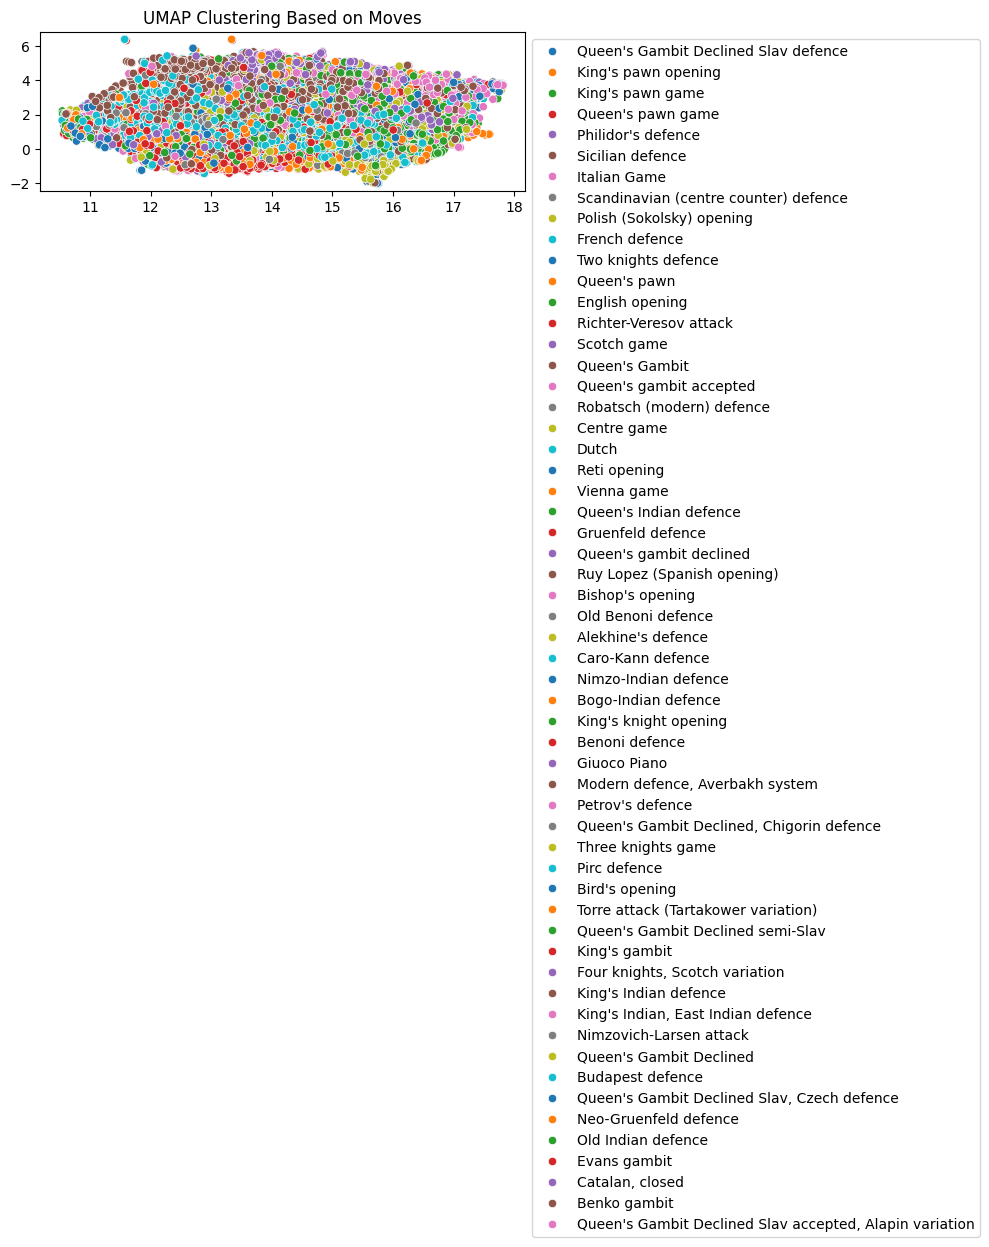

In [16]:
vectorizer = CountVectorizer()

encoded_moves = vectorizer.fit_transform(data['moves'])

encoded_moves_dense = encoded_moves.toarray()

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_moves_dense)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['grouped_opening'], palette='tab10')
plt.title('t-SNE Clustering Based on Moves')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = reducer.fit_transform(encoded_moves_dense)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['grouped_opening'], palette='tab10')
plt.title('UMAP Clustering Based on Moves')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# silhouette_tsne = silhouette_score(tsne_results, data['grouped_opening'])
# print(f"Silhouette Score for t-SNE: {silhouette_tsne}")

# silhouette_umap = silhouette_score(umap_results, data['grouped_opening'])
# print(f"Silhouette Score for UMAP: {silhouette_umap}")



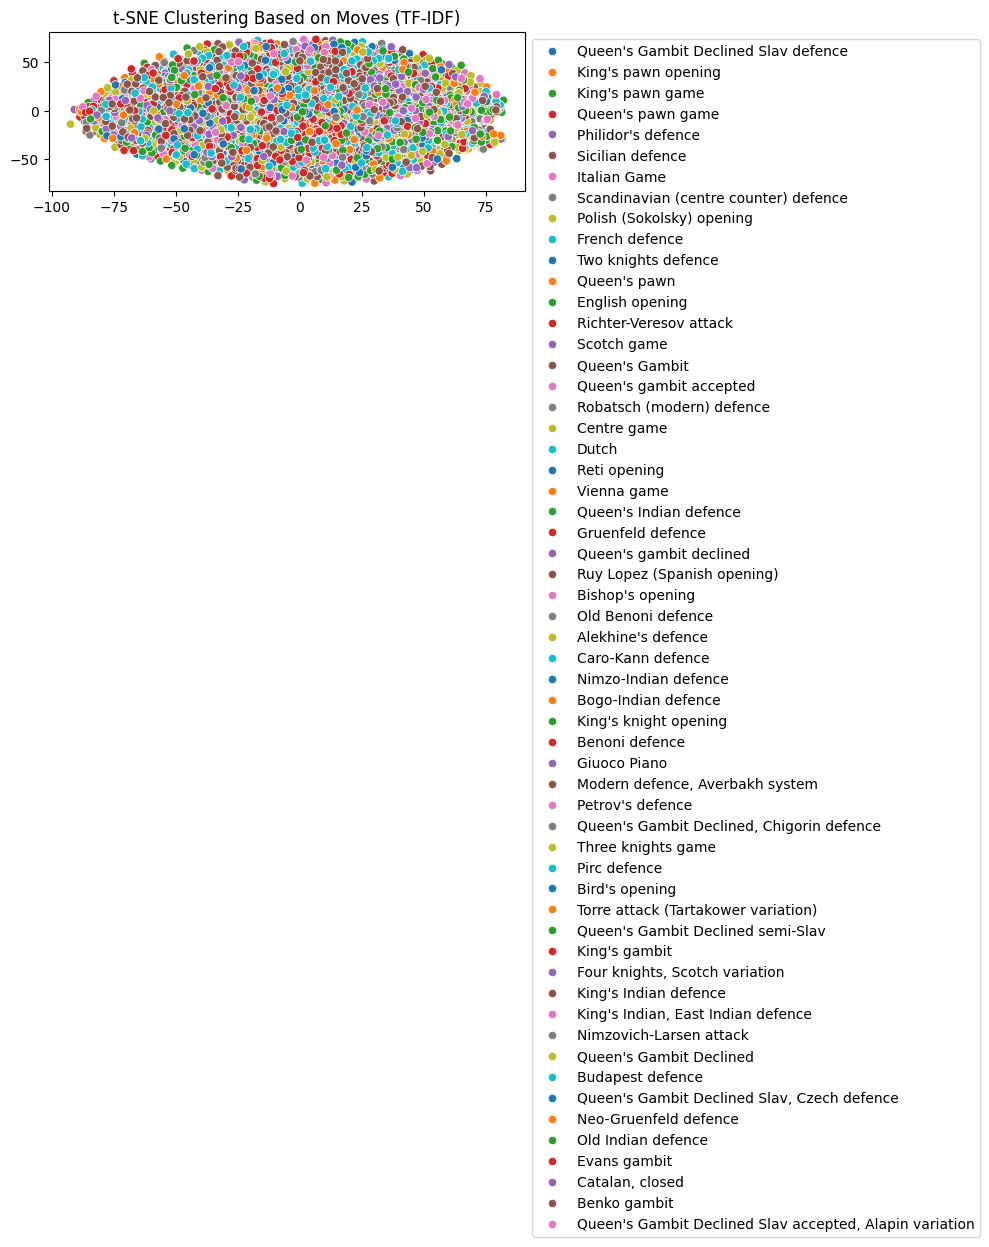

/mnt/c/Users/Maxwell Bruce/Desktop/AML/ChessOpenningMovePredictor/myenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


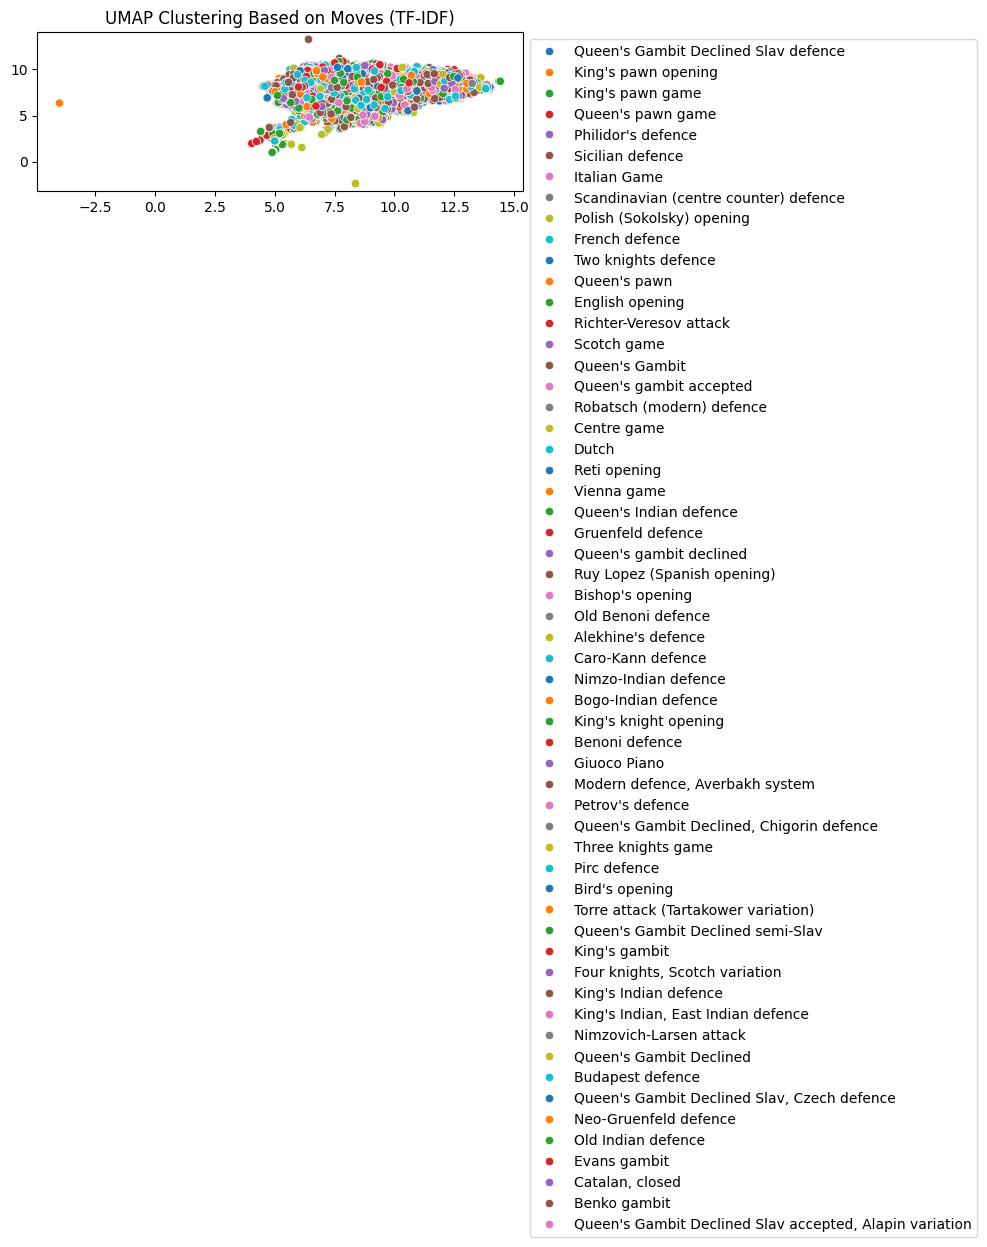

In [17]:
tfidf_vectorizer = TfidfVectorizer()

encoded_moves_tfidf = tfidf_vectorizer.fit_transform(data['moves'])

encoded_moves_tfidf_dense = encoded_moves_tfidf.toarray()

tsne = TSNE(n_components=2, random_state=42)
tsne_results_tfidf = tsne.fit_transform(encoded_moves_tfidf_dense)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results_tfidf[:, 0], y=tsne_results_tfidf[:, 1], hue=data['grouped_opening'], palette='tab10')
plt.title('t-SNE Clustering Based on Moves (TF-IDF)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results_tfidf = reducer.fit_transform(encoded_moves_tfidf_dense)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_results_tfidf[:, 0], y=umap_results_tfidf[:, 1], hue=data['grouped_opening'], palette='tab10')
plt.title('UMAP Clustering Based on Moves (TF-IDF)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# silhouette_tsne = silhouette_score(tsne_results, data['grouped_opening'])
# print(f"Silhouette Score for t-SNE: {silhouette_tsne}")

# silhouette_umap = silhouette_score(umap_results, data['grouped_opening'])
# print(f"Silhouette Score for UMAP: {silhouette_umap}")


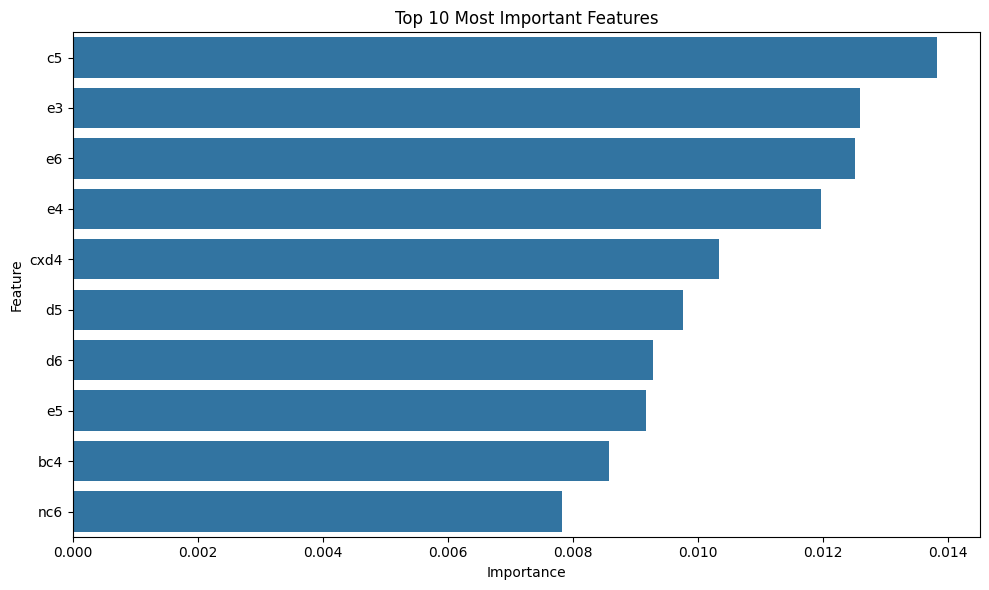

In [22]:

vectorizer = CountVectorizer()

encoded_moves = vectorizer.fit_transform(data['moves'])

clf = RandomForestClassifier(random_state=42)
clf.fit(encoded_moves, data['grouped_opening'])

importances = clf.feature_importances_
features = vectorizer.get_feature_names_out()

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features['Importance'], y=top_10_features['Feature'])
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


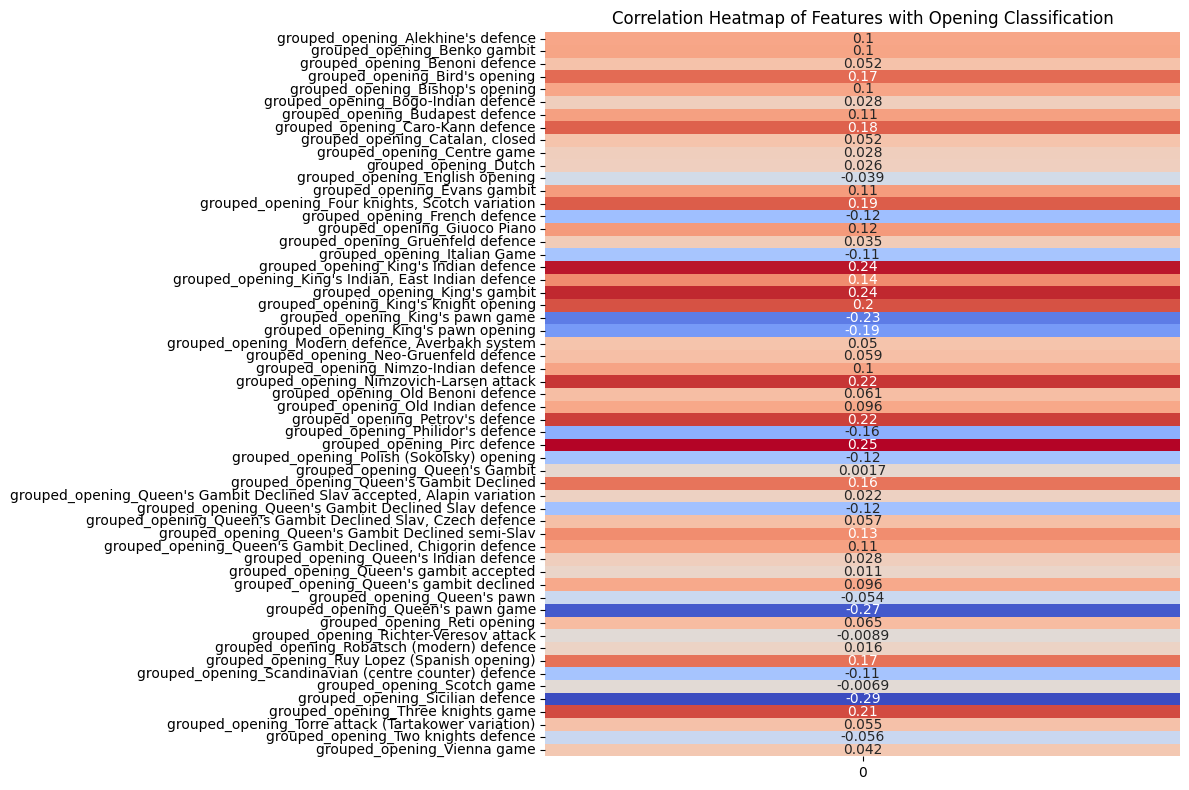

In [20]:
encoded_df = pd.DataFrame(encoded_openings, columns=encoder.get_feature_names_out(['grouped_opening']))

target_series = pd.Series(data['grouped_opening'].factorize()[0])

corr_matrix = encoded_df.corrwith(target_series)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.values.reshape(-1, 1), annot=True, cmap='coolwarm', cbar=False, 
            yticklabels=encoded_df.columns)
plt.title('Correlation Heatmap of Features with Opening Classification')
plt.tight_layout()
plt.show()

# Feature Engineering

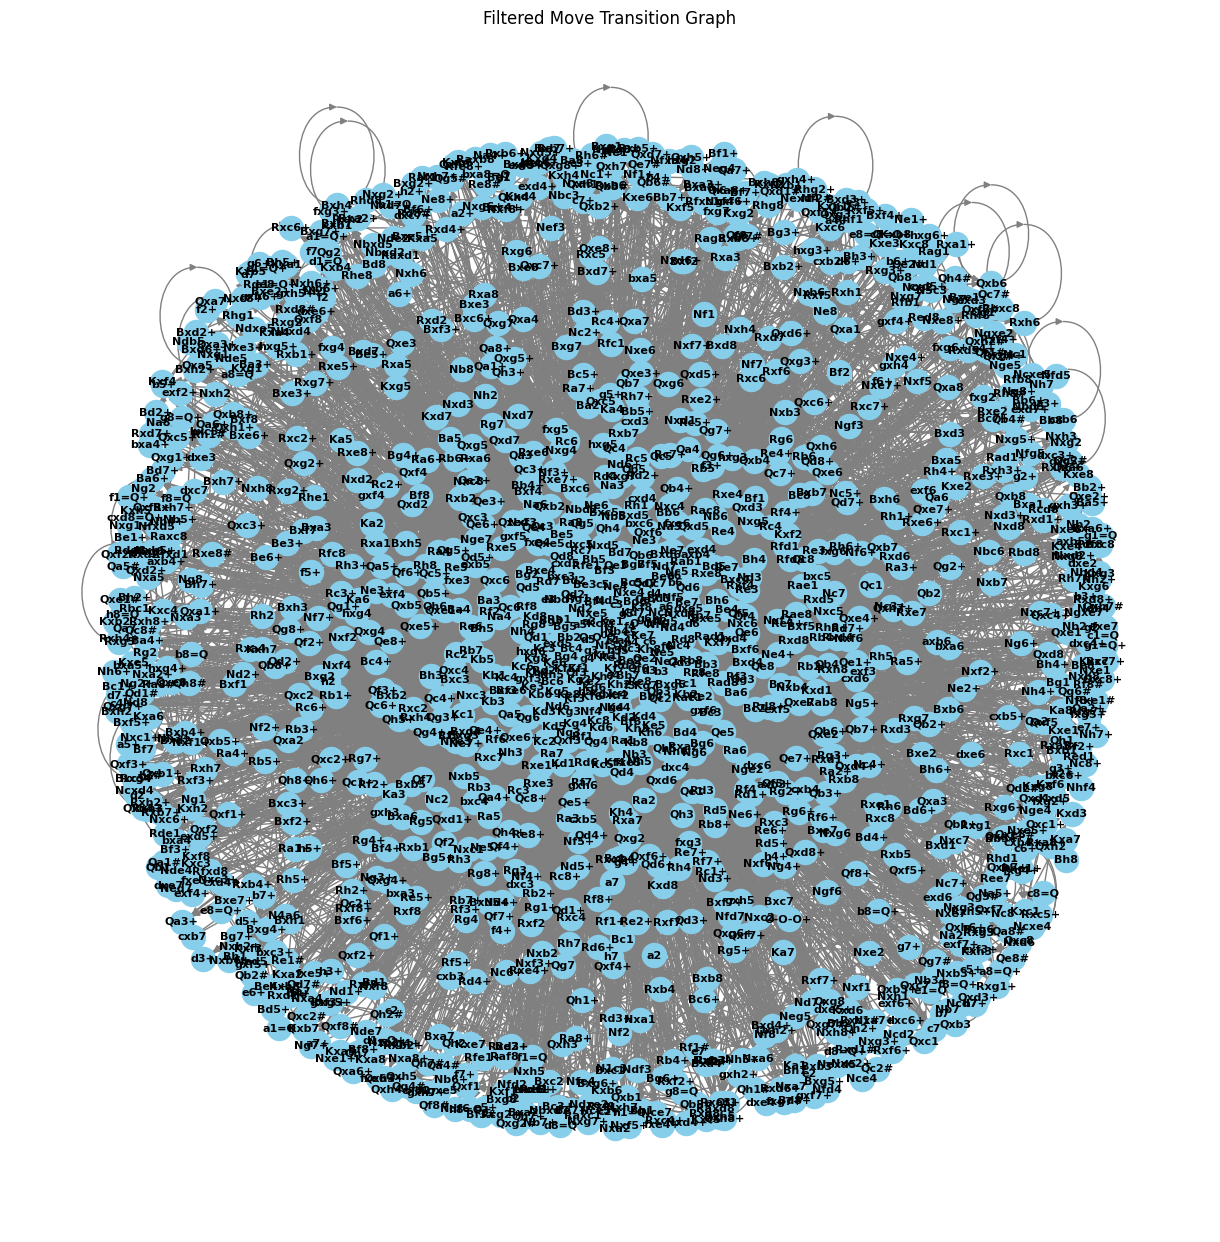

In [24]:
def extract_move_pairs(moves):
    # Split the moves into a list
    move_list = moves.split()
    # Create consecutive pairs of moves
    return [(move_list[i], move_list[i+1]) for i in range(len(move_list)-1)]

# Apply the function to create the 'move_pairs' column
data['move_pairs'] = data['moves'].apply(extract_move_pairs)

# Count the frequency of each transition
transition_counter = Counter([pair for pairs in data['move_pairs'] for pair in pairs])

# Filter edges by frequency (e.g., keep only transitions with frequency > 5)
filtered_edges = [edge for edge, count in transition_counter.items() if count > 5]

# Create a filtered graph
G_filtered = nx.DiGraph()
G_filtered.add_edges_from(filtered_edges)

# Draw the filtered graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_filtered, k=0.5)
nx.draw(G_filtered, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=8, font_weight='bold', edge_color='gray', arrowsize=10)
plt.title('Filtered Move Transition Graph')
plt.show()

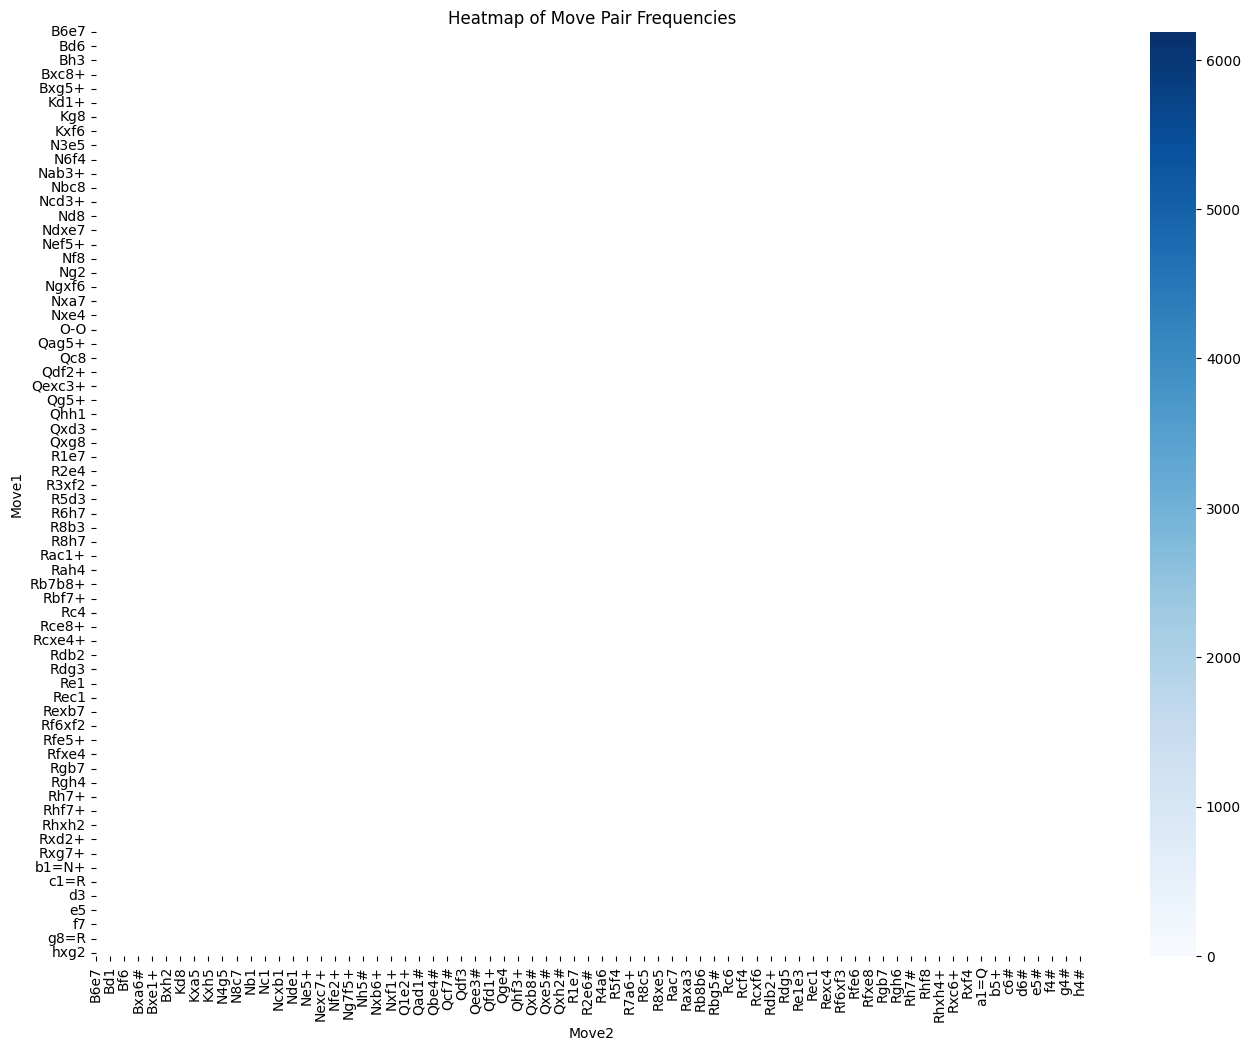

: 

In [25]:
# move_pairs = []
# for moves in data['moves']:
#     moves_split = moves.split()
#     move_pairs.extend([(moves_split[i], moves_split[i+1]) for i in range(len(moves_split)-1)])

# move_pair_df = pd.DataFrame(move_pairs, columns=['Move1', 'Move2'])
# move_pair_freq = move_pair_df.groupby(['Move1', 'Move2']).size().unstack(fill_value=0)

# plt.figure(figsize=(16, 12))
# sns.heatmap(move_pair_freq, cmap='Blues', annot=False, linewidths=.5)
# plt.title('Heatmap of Move Pair Frequencies')
# plt.xlabel('Move2')
# plt.ylabel('Move1')
# plt.show()

In [26]:
data['moves_list'] = data['moves'].apply(lambda x: x.split()[:10])  
data['target'] = data['grouped_opening'] 

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded_moves = onehot_encoder.fit_transform(data['moves_list'].apply(lambda x: ' '.join(x)).values.reshape(-1, 1))

label_encoder = LabelEncoder()
all_moves = [move for moves in data['moves_list'] for move in moves]
label_encoder.fit(all_moves)

label_encoded_moves = [label_encoder.transform(moves) for moves in data['moves_list']]
padded_label_encoded_moves = pad_sequences(label_encoded_moves, maxlen=10, padding='post', value=-1)

embedded_model = Pipeline([
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(onehot_encoded_moves, data['target'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
onehot_accuracy = accuracy_score(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(padded_label_encoded_moves, data['target'], test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
label_accuracy = accuracy_score(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(padded_label_encoded_moves, data['target'], test_size=0.2, random_state=42)
embedded_model.fit(X_train, y_train)
y_pred = embedded_model.predict(X_test)
embedding_accuracy = accuracy_score(y_test, y_pred)

print(f"One-Hot Encoding Accuracy: {onehot_accuracy:.4f}")
print(f"Label Encoding Accuracy: {label_accuracy:.4f}")
print(f"Embedding Layer Accuracy: {embedding_accuracy:.4f}")



# Dimension Reduction

In [ ]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(encoded_openings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=data['grouped_opening'], palette='tab10', legend='full')
plt.title('PCA Plot of Encoded Move Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_openings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['grouped_opening'], palette='tab10', legend='full')
plt.title('t-SNE Plot of Encoded Move Sequences')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = reducer.fit_transform(encoded_openings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['grouped_opening'], palette='tab10', legend='full')
plt.title('UMAP Plot of Encoded Move Sequences')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()
